In [61]:
import numpy as np
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

def minimum_image_vec(dxy, Lx, Ly):
    dxy[:, 0] -= np.round(dxy[:, 0] / Lx) * Lx
    dxy[:, 1] -= np.round(dxy[:, 1] / Ly) * Ly
    return dxy

def compute_psi6(tree, pos, Lx, Ly, r_cut):
    """ψ6(i) with the *same* cKDTree used later for pairs."""
    nbr_lists = tree.query_ball_point(pos, r_cut)
    psi6 = np.empty(len(pos), dtype=np.complex128)

    for i, nbrs in enumerate(nbr_lists):
        if i in nbrs:
            nbrs.remove(i)
        if not nbrs:
            psi6[i] = 0.0
            continue
        vecs = pos[nbrs] - pos[i]
        vecs = minimum_image_vec(vecs, Lx, Ly)
        theta = np.arctan2(vecs[:, 1], vecs[:, 0])
        psi6[i] = np.exp(1j * 6.0 * theta).mean()
    return psi6

def g6(pos, dr, r_cut=1.2):
    """
    Bond‑orientational correlation g6(r) without any bin‑threshold masking.
    """
    # ----- box size ----------------------------------------------------
    Lx, Ly = np.ptp(pos[:, 0])+20, np.ptp(pos[:, 1])+20
    r_max = 0.5*min(Lx, Ly)

    # ----- neighbour tree ---------------------------------------------
    tree = cKDTree(pos)
    psi6 = compute_psi6(tree, pos, Lx, Ly, r_cut)
    psi6_mag2 = (np.abs(psi6) ** 2).mean()

    # ----- all pairs up to r_max --------------------------------------
    pairs = np.array(list(tree.query_pairs(r_max)))
    dxy = pos[pairs[:, 1]] - pos[pairs[:, 0]]
    dxy = minimum_image_vec(dxy, Lx, Ly)
    r = np.hypot(dxy[:, 0], dxy[:, 1])

    # ----- histogram ---------------------------------------------------
    nbins = int(np.ceil(r_max / dr))
    bin_idx = np.floor(r / dr).astype(np.int64)

    num = np.zeros(nbins, dtype=np.complex128)
    counts = np.bincount(bin_idx, minlength=nbins)
    weights = psi6[pairs[:, 0]] * np.conj(psi6[pairs[:, 1]])
    np.add.at(num, bin_idx, weights)

    # ----- g6(r) -------------------------------------------------------
    r_cent = (np.arange(nbins) + 0.5) * dr
    with np.errstate(divide="ignore", invalid="ignore"):
        g6_r = (num / counts).real / psi6_mag2   
    g6_r[counts == 0] = np.nan                  # bins with no statistics

    return r_cent, g6_r, counts                


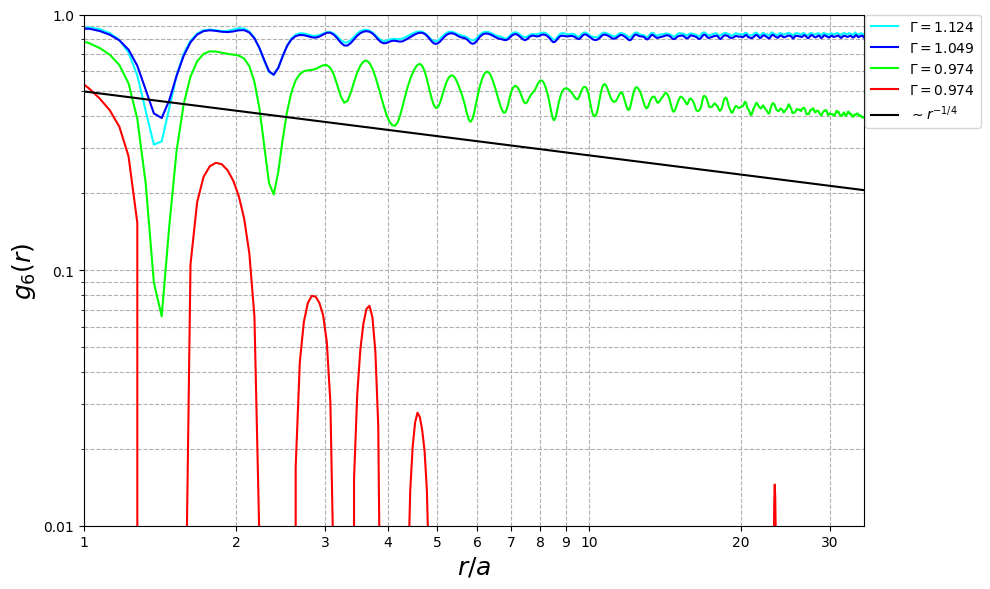

In [67]:
a = 1.42

plt.figure(figsize=(10,6))

for label, fname, color, rcut in [
        (r'$\Gamma = 1.124$',  'data/7000K.txt', "cyan",    1.3),
        (r'$\Gamma = 1.049$',  'data/7500K.txt', "b",    1.3),
        (r'$\Gamma = 0.974$',  'data/8000K.txt', "lime",    1.3),
        (r'$\Gamma = 0.974$',  'data/9000K.txt', "red",    1.3)]:
    
    pos = np.loadtxt(fname)[:,2:4] / a        # scale to r/a units

    r, g6_r, _ = g6(pos, dr=0.05, r_cut=rcut)
    g6_smooth = gaussian_filter1d(np.nan_to_num(g6_r, nan=0.0), sigma=1.5)
    plt.loglog(r, g6_smooth, c=color, label=label, lw=1.5)


plt.loglog(r, 0.5*r**(-1/4), c="k", label=r"$\sim r^{-1/4}$")
x_ticks = list(range(1, 11)) + [20, 30]
plt.xticks(x_ticks, [str(t) for t in x_ticks])
plt.yticks([1.0, 0.1, 0.01], ["1.0", "0.1", "0.01"])

plt.xlabel(r'$r/a$', fontsize=18)
plt.ylabel(r'$g_6(r)$', fontsize=18)
plt.xlim(1, 35)
plt.ylim(1e-2, 1)
plt.grid(True, which="both", ls="--")
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1), borderaxespad=0.)
plt.tight_layout()
plt.show()

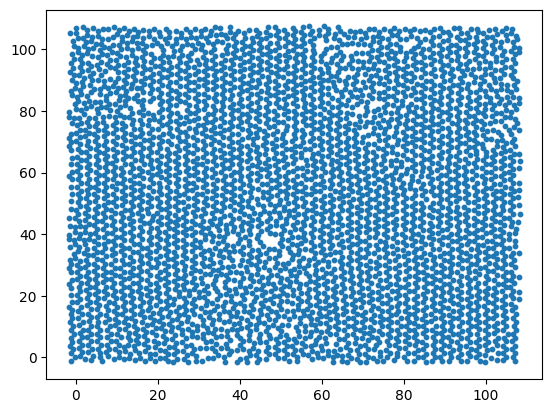

In [65]:
p = np.loadtxt("data/8000K.txt")[:,2:4]      # scale to r/a units

plt.scatter(p[:,0], p[:,1], s = 10)

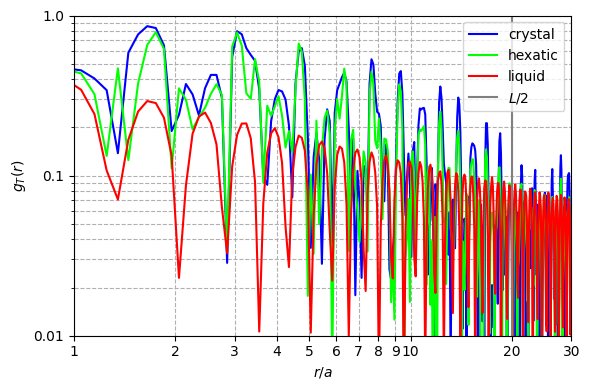

In [46]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Bond‑orientational g6(r)  ✚  Translational gT(r) correlation for graphene.
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
from scipy.ndimage import gaussian_filter1d

# ---------------------------------------------------------------
# build the six first‑shell reciprocal‑lattice vectors |G| = 4π/3 (units of 1/a)
# ---------------------------------------------------------------
def build_first_shell_G():
    angles = np.arange(6) * np.pi/3           # 0°, 60°, …, 300°
    G_mag  = 4*np.pi/3                        # dimensionless (r is in units of a)
    return np.column_stack((np.cos(angles), np.sin(angles))) * G_mag

G_vecs_all = build_first_shell_G() 

# ---------------------------------------------------------------
# translational correlation averaged over 1 or many G‑vectors
# ---------------------------------------------------------------
def gT(pos, G_vecs, dr=0.05, r_max=None):
    """
    pos    – (N,2) coordinates already scaled by a_nn  (dimensionless)
    G_vecs – (6,2) array from build_first_shell_G()   OR a single (2,) vector
    dr     – bin width
    """
    Lx, Ly = np.ptp(pos[:,0]) + 10, np.ptp(pos[:,1]) + 10
    r_max  = 0.55 * min(Lx, Ly) if r_max is None else r_max

    tree  = cKDTree(pos)
    pairs = np.array(list(tree.query_pairs(r_max)))        # (M,2)

    dxy   = minimum_image_vec(pos[pairs[:,1]] - pos[pairs[:,0]], Lx, Ly)
    r     = np.hypot(dxy[:,0], dxy[:,1])

    # ---- complex weights --------------------------------------------
    if G_vecs.ndim == 1:                       # single vector
        phase   = dxy @ G_vecs                # (M,)
        weights = np.exp(1j*phase)
    else:                                      # 6 vectors -> average over l
        phase   = dxy @ G_vecs.T              # (M,6)
        weights = np.exp(1j*phase).mean(axis=1)   #  (1/6) Σ_l e^{i q_l·Δr}

    # ---- histogram ---------------------------------------------------
    nbins   = int(np.ceil(r_max/dr))
    bin_idx = np.floor(r/dr).astype(np.int64)

    num     = np.zeros(nbins, dtype=np.complex128)
    N_r     = np.bincount(bin_idx, minlength=nbins)        # N_r from the paper
    np.add.at(num, bin_idx, weights)

    r_cent  = (np.arange(nbins) + 0.5) * dr
    with np.errstate(divide="ignore", invalid="ignore"):
        gT_r = (num / N_r).real            # divide only by N_r  ✔
    gT_r[N_r == 0] = np.nan

    return r_cent, gT_r, N_r

plt.figure(figsize=(6,4))

for label, fname, color in [
        ('crystal', 'data/crystal.txt',  "b"),
        ('hexatic', 'data/hexatic.txt',  "lime"),
        ('liquid',  'data/liquid.txt',   "r")]:

    pos = np.loadtxt(fname)[:, 2:4] / a          # scale to units of a
    r, gT_r, _ = gT(pos, G_vecs_all, dr=0.1)       # uses the 6 vectors

    gT_smooth = gaussian_filter1d(np.nan_to_num(gT_r, nan=0.0), sigma=1.5)
    plt.loglog(r, np.abs(gT_r), c=color, label=label)

# identical cosmetics to the g6 plot
x_ticks = list(range(1, 11)) + [20, 30]
plt.xticks(x_ticks, [str(t) for t in x_ticks])
plt.yticks([1.0, 0.1, 0.01], ["1.0", "0.1", "0.01"])

plt.xlabel(r'$r/a$')
plt.ylabel(r'$g_T(r)$')
plt.axvline(20, c="gray", label="$L/2$")
plt.xlim(1, 30)
plt.ylim(1e-2, 1)
plt.grid(True, which="both", ls="--")
plt.legend()
plt.tight_layout()
plt.show()
